In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

from iq_mixer import IQMixer
from cic3d128 import CIC3D128
from seq_fir import FIR
from cordic_atan2 import CAtan2
from common import width_convert

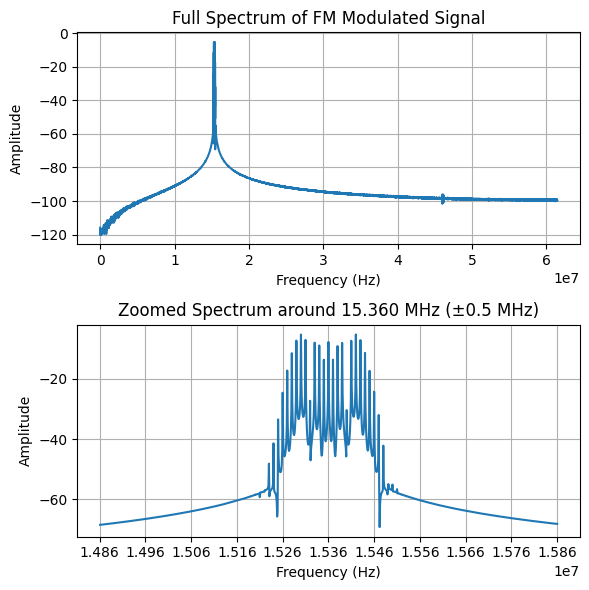

In [2]:
sample_rate = 122.88e6

# read fm modulated data from CSV file
input = np.loadtxt("fm_10k_75k_15_36M.csv", delimiter=",", dtype=np.float64)

# plot the spectrum of the input signal with zoomed view around max amplitude
N = len(input)
T = 1.0 / sample_rate
yf = fft(input)
xf = fftfreq(N, T)[:N // 2]
magnitude = 2.0 / N * np.abs(yf[0:N // 2])

# convert vpp to vrms
magnitude = magnitude / (2 * np.sqrt(2))
# convert to power in dBm assuming 50 ohm load
magnitude = 10 * np.log10((magnitude ** 2) / 50 * 1000 + 1e-12)  # add small value to avoid log(0)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# full spectrum
axes[0].plot(xf, magnitude)
axes[0].set_title("Full Spectrum of FM Modulated Signal")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)

# zoomed spectrum centered at max amplitude ±0.5 MHz
peak_idx = np.argmax(magnitude)
center_freq = 15.36e6 # xf[peak_idx]
mask = (xf >= center_freq - 0.5e6) & (xf <= center_freq + 0.5e6)
axes[1].plot(xf[mask], magnitude[mask])
axes[1].set_title(f"Zoomed Spectrum around {center_freq/1e6:.3f} MHz (±0.5 MHz)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)
# set x-axis grid lines at every 100 kHz cenetred at center_freq
xticks = np.arange(center_freq - 0.5e6, center_freq + 0.5e6 + 1, 100e3)
axes[1].set_xticks(xticks)

plt.tight_layout()
plt.show()


In [3]:
#convert input to 16bits 2'complement in uint16 format
input_uint16 = np.clip(np.round(input * 32767), -32768, 32767).astype(np.int16).astype(np.uint16)

# mixed iq signal traces
mixed_output_i = np.zeros_like(input_uint16, dtype=np.uint16)
mixed_output_q = np.zeros_like(input_uint16, dtype=np.uint16)

# cic decimated output traces
decimated_output_i = np.zeros(len(input_uint16), dtype=np.uint64)
decimated_output_q = np.zeros(len(input_uint16), dtype=np.uint64)
decimated_output_i_valid = np.zeros(len(input_uint16), dtype=bool)
decimated_output_q_valid = np.zeros(len(input_uint16), dtype=bool)

# cic compensation fir filter traces
fir_output_i = np.zeros(len(input_uint16), dtype=np.uint64)
fir_output_i_valid = np.zeros(len(input_uint16), dtype=bool)
fir_output_q = np.zeros(len(input_uint16), dtype=np.uint64)
fir_output_q_valid = np.zeros(len(input_uint16), dtype=bool)

# atan2 output traces
atan2_output = np.zeros(len(input_uint16), dtype=np.uint32)
atan2_output_valid = np.zeros(len(input_uint16), dtype=bool)

# create iq mixer instance
mixer = IQMixer(exec_path="../../build/exec/iq_mixer", freq=15.36e6, sample_rate=sample_rate, silent=True)

# create cic decimator instance
cic_decimator_i = CIC3D128(exec_path="../../build/exec/cic3d128", silent=True)
cic_decimator_q = CIC3D128(exec_path="../../build/exec/cic3d128", silent=True)

# create fir filter instance
fir_filter_i = FIR(exec_path="../../build/exec/cic3d128comp", silent=True)
fir_filter_q = FIR(exec_path="../../build/exec/cic3d128comp", silent=True)

# create cordic atan2 instance
cordic_atan2 = CAtan2(exec_path="../../build/exec/atan2", silent=True)

try:
    for idx, sample in enumerate(input_uint16):
        i, q = mixer.forward(sample)
        valid_i, dec_i = cic_decimator_i.forward(i)
        valid_q, dec_q = cic_decimator_q.forward(q)
        
        # convert 37-bit cic output to 18-bit fir input
        dec_i_18 = width_convert(dec_i, from_bits=37, to_bits=18)
        dec_q_18 = width_convert(dec_q, from_bits=37, to_bits=18)
        # to np.uint32
        dec_i_18 = np.uint32(dec_i_18 & np.uint64(0xFFFFFFFF))
        dec_q_18 = np.uint32(dec_q_18 & np.uint64(0xFFFFFFFF))
        
        valid_fir_i, fir_i = fir_filter_i.forward(valid_i, dec_i_18)
        valid_fir_q, fir_q = fir_filter_q.forward(valid_q, dec_q_18)

        # get the lower 35 bits of fir output
        fir_i_35 = fir_i & np.uint64(0x7FFFFFFFF)
        fir_q_35 = fir_q & np.uint64(0x7FFFFFFFF)
        # convert to np.uint32
        fir_i_35 = fir_i_35 >> np.uint64(3)
        fir_q_35 = fir_q_35 >> np.uint64(3)
        fir_i_35 = np.uint32(fir_i_35 & np.uint64(0xFFFFFFFF))
        fir_q_35 = np.uint32(fir_q_35 & np.uint64(0xFFFFFFFF))

        valid_atan2, atan2_res = cordic_atan2.forward(valid_fir_i and valid_fir_q, fir_q_35, fir_i_35)
        
        mixed_output_i[idx] = i
        mixed_output_q[idx] = q
        decimated_output_i[idx] = dec_i
        decimated_output_q[idx] = dec_q
        decimated_output_i_valid[idx] = valid_i
        decimated_output_q_valid[idx] = valid_q
        fir_output_i[idx] = fir_i
        fir_output_q[idx] = fir_q
        fir_output_i_valid[idx] = valid_fir_i
        fir_output_q_valid[idx] = valid_fir_q
        atan2_output[idx] = atan2_res
        atan2_output_valid[idx] = valid_atan2

finally:
    mixer.terminate()
    cic_decimator_i.terminate()
    cic_decimator_q.terminate()
    fir_filter_i.terminate()
    fir_filter_q.terminate()

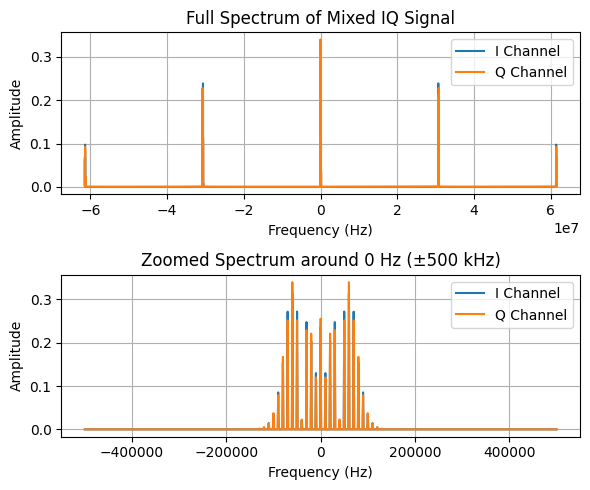

In [14]:
# convert iq outputs back to float32
mixed_output_i_float = (mixed_output_i.astype(np.int16).astype(np.float32)) / 32768.0
mixed_output_q_float = (mixed_output_q.astype(np.int16).astype(np.float32)) / 32768.0

# plot the double-side spectrum of the mixed iq signal with zoomed view around +- 500kHz
N = len(mixed_output_i)
T = 1.0 / sample_rate

yf_i = fft(mixed_output_i_float)  # center around 0
yf_q = fft(mixed_output_q_float)  # center around 0

xf = fftfreq(N, T)

magnitude_i = 2.0 / N * np.abs(yf_i)
magnitude_q = 2.0 / N * np.abs(yf_q)

xf = fftshift(xf)
magnitude_i = fftshift(magnitude_i)
magnitude_q = fftshift(magnitude_q)

fig, axes = plt.subplots(2, 1, figsize=(6, 5))
# full spectrum
axes[0].plot(xf, magnitude_i, label='I Channel')
axes[0].plot(xf, magnitude_q, label='Q Channel')
axes[0].set_title("Full Spectrum of Mixed IQ Signal")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude")
axes[0].legend()
axes[0].grid(True)

# zoomed spectrum centered at 0 Hz ±500 kHz
mask = (xf >= -500e3) & (xf <= 500e3)
axes[1].plot(xf[mask], magnitude_i[mask], label='I Channel')
axes[1].plot(xf[mask], magnitude_q[mask], label='Q Channel')
axes[1].set_title("Zoomed Spectrum around 0 Hz (±500 kHz)")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()


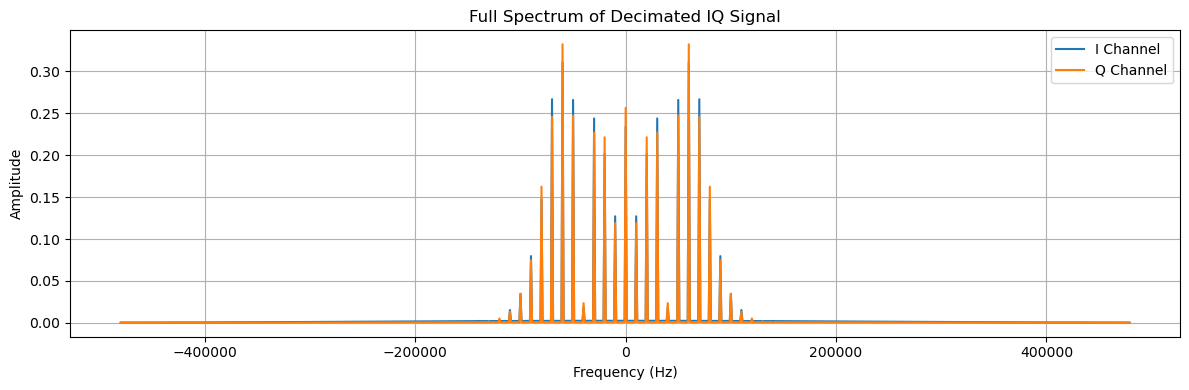

In [ ]:
#keep only valid decimated outputs
decimated_output_i_filtered = decimated_output_i[decimated_output_i_valid]
decimated_output_q_filtered = decimated_output_q[decimated_output_q_valid]

# convert cic outputs (37bits signed) back to float32
decimated_output_i_float = (decimated_output_i_filtered.astype(np.int64).astype(np.float32)) / (2**36)
decimated_output_q_float = (decimated_output_q_filtered.astype(np.int64).astype(np.float32)) / (2**36)

# plot the double-side spectrum of the decimated iq signal 
N = len(decimated_output_i_float)
T = 1.0 / (sample_rate / 128)  # adjusted for decimation

yf_i = fft(decimated_output_i_float)  # center around 0
yf_i = fftshift(yf_i)
yf_q = fft(decimated_output_q_float)  # center around 0
yf_q = fftshift(yf_q)

xf = fftfreq(N, T)
xf = fftshift(xf)

magnitude_i = 2.0 / N * np.abs(yf_i)
magnitude_q = 2.0 / N * np.abs(yf_q)
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
# full spectrum
axes.plot(xf, magnitude_i, label='I Channel')
axes.plot(xf, magnitude_q, label='Q Channel')
axes.set_title("Full Spectrum of Decimated IQ Signal")
axes.set_xlabel("Frequency (Hz)")
axes.set_ylabel("Amplitude")
axes.legend()
axes.grid(True)

plt.tight_layout()


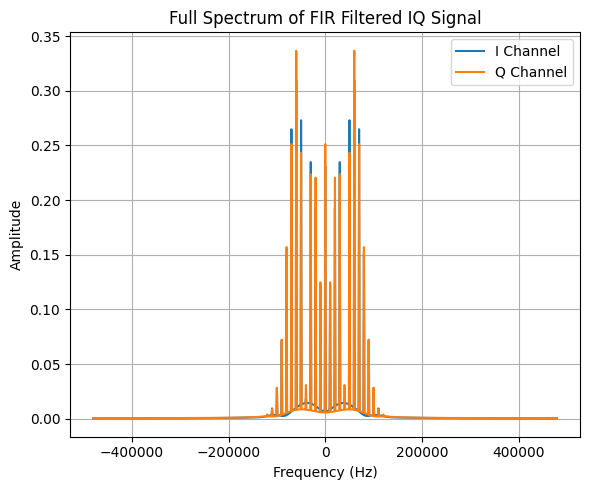

In [ ]:
# keep only valid fir outputs
fir_output_i_filtered = fir_output_i[fir_output_i_valid]
fir_output_q_filtered = fir_output_q[fir_output_q_valid]

# convert fir outputs (48bits signed) back to float32
fir_output_i_float = (fir_output_i_filtered.astype(np.int64).astype(np.float32)) / (2**34)
fir_output_q_float = (fir_output_q_filtered.astype(np.int64).astype(np.float32)) / (2**34)

# plot the double-side spectrum of the fir filtered iq signal
N = len(fir_output_i_float)
T = 1.0 / (sample_rate / 128)  # adjusted for decimation

yf_i = fft(fir_output_i_float)  # center around 0
yf_i = fftshift(yf_i)
yf_q = fft(fir_output_q_float)  # center around 0
yf_q = fftshift(yf_q)  

xf = fftfreq(N, T)
xf = fftshift(xf)


magnitude_i = 2.0 / N * np.abs(yf_i)
magnitude_q = 2.0 / N * np.abs(yf_q)
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
# full spectrum
axes.plot(xf, magnitude_i, label='I Channel')
axes.plot(xf, magnitude_q, label='Q Channel')

axes.set_title("Full Spectrum of FIR Filtered IQ Signal")
axes.set_xlabel("Frequency (Hz)")
axes.set_ylabel("Amplitude")
axes.legend()
axes.grid(True)
plt.tight_layout()

(array([-0.6274776 , -0.49741298, -0.27006736,  0.01391446], dtype=float32),
 array([-0.16424476, -0.41017246, -0.5811543 , -0.6371264 ], dtype=float32),
 array([-2.3256013, -2.3867877, -1.7432866, -1.2533293], dtype=float32))

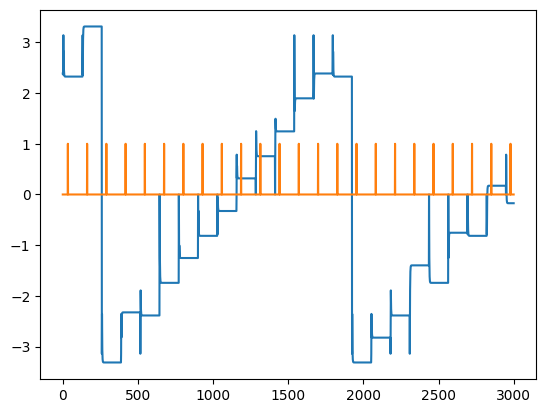

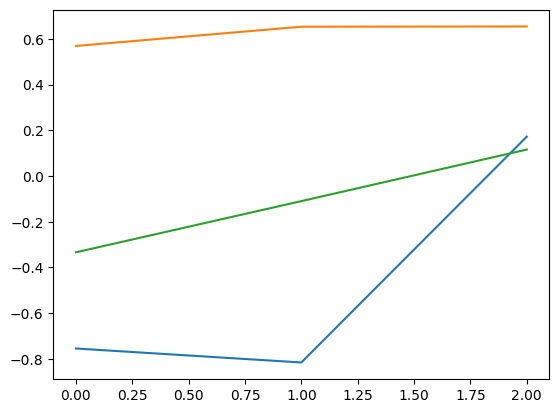

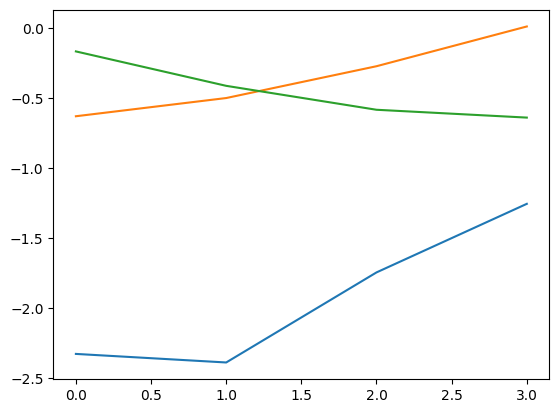

In [23]:
# convert atan2 outputs (signed q2.29) to float32
atan2_output_filtered = atan2_output[:]
atan2_output_float = (atan2_output_filtered.astype(np.int32).astype(np.float32)) / (2**29)

# convert fir outputs (48bits signed) back to float32
fir_output_i_float = (fir_output_i.astype(np.int64).astype(np.float32)) / (2**34)
fir_output_q_float = (fir_output_q.astype(np.int64).astype(np.float32)) / (2**34)

plt.plot(atan2_output_float[4000:7000])
plt.plot(atan2_output_valid[4000:7000])
plt.figure()
plt.plot(atan2_output_float[6500:7000][atan2_output_valid[6500:7000]][:-1])
plt.plot(fir_output_i_float[6500:7000][fir_output_i_valid[6500:7000]][1:])
plt.plot(fir_output_q_float[6500:7000][fir_output_q_valid[6500:7000]][1:])
plt.figure()
plt.plot(atan2_output_float[4000:7000][atan2_output_valid[4000:7000]][3:7])
plt.plot(fir_output_i_float[4000:7000][fir_output_i_valid[4000:7000]][2:6])
plt.plot(fir_output_q_float[4000:7000][fir_output_q_valid[4000:7000]][2:6])

fir_output_i_float[4000:7000][fir_output_i_valid[4000:7000]][2:6], fir_output_q_float[4000:7000][fir_output_q_valid[4000:7000]][2:6], atan2_output_float[4000:7000][atan2_output_valid[4000:7000]][3:7]

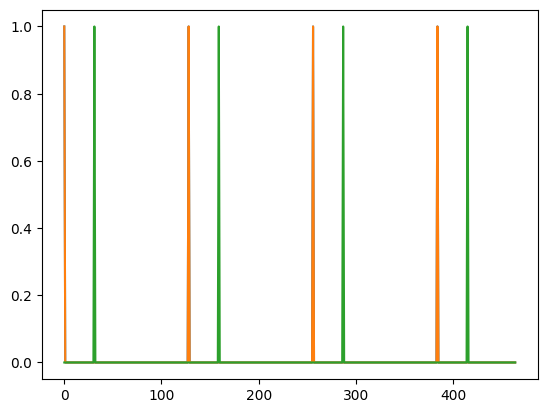

In [21]:
plt.plot(fir_output_i_valid[35:500])
plt.plot(fir_output_q_valid[35:500])

plt.plot(atan2_output_valid[35:500])

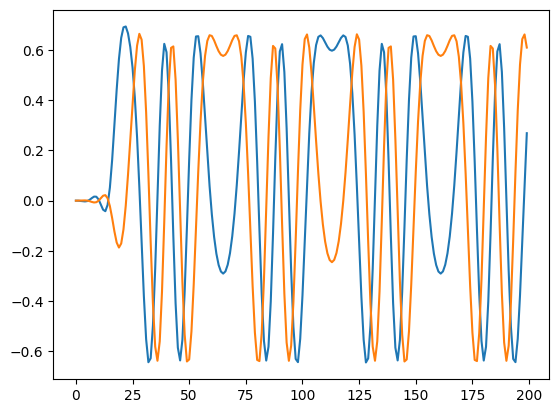

In [16]:
# get the lower 35 bits of fir output
fir_i_35 = fir_output_i_filtered & np.uint64(0x7FFFFFFFF)
fir_q_35 = fir_output_q_filtered & np.uint64(0x7FFFFFFFF)
# convert to np.uint32
fir_i_35 = fir_i_35 >> np.uint64(3)
fir_q_35 = fir_q_35 >> np.uint64(3)
fir_i_35 = np.uint32(fir_i_35 & np.uint64(0xFFFFFFFF))
fir_q_35 = np.uint32(fir_q_35 & np.uint64(0xFFFFFFFF))
# convert to float32
fir_i_35_float = (fir_i_35.astype(np.int32).astype(np.float32)) / (2**31)
fir_q_35_float = (fir_q_35.astype(np.int32).astype(np.float32)) / (2**31)

plt.plot(fir_i_35_float[:200])
plt.plot(fir_q_35_float[:200])
# ref = np.atan2(fir_q_35_float, fir_i_35_float)
# plt.plot(np.unwrap(ref[:200]))

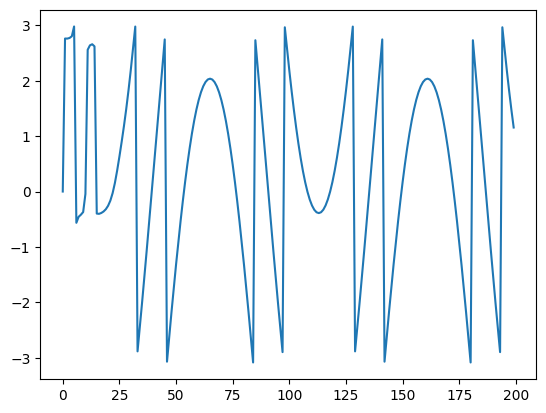

In [26]:
ref = np.atan2(fir_output_q_float, fir_output_i_float)
plt.plot(ref[:200])

In [12]:
np.max(fir_output_q_float)

np.float32(0.66405016)